## Import the libraries

In [ ]:
# For data handling and EDA
import pandas as pd
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# For NLP and ML
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
import nltk
import spacy

## Using the whole dataset

### Load the whole dataset to Pandas

In [ ]:
# Load the annotations metadata csv to get label info
annot = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot['message']=''
# Loop through all lines
for i in range(len(annot['file_id'])):
    # Get current filename
    filename = annot['file_id'][i]
    # Open the file and read the contents
    with open('hate-speech-dataset-master/all_files/' +filename +'.txt') as f:
        contents= f.read()
    f.close()
    # Add contents to the message column
    annot['message'][i]=contents
# Drop file id
annot.drop(columns=['file_id'],inplace=True)

### EDA and Pre-Processing

In [ ]:
# DataFrame information
annot.info()

In [ ]:
# Check the classes and their value counts
annot['label'].value_counts()

Based on the original paper, there are a total of 10944 sentences, 9507 of them are classified as no hate speech, 1196 are classified as hate speech, 168 are related to hate speech but depends on content and 73 are non English sentences, classified as idk/skip. For the purpose of this research, relation and idk/skip classes will be dropped completely in order to make the problem a binary classification.

In [ ]:
# Keep sentences classified only as noHate and hate
cleanPosts = annot[(annot['label'] != 'relation') & (annot['label'] != 'idk/skip')]
# Reset index
cleanPosts=cleanPosts.reset_index(drop=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

In [ ]:
# WordCloud for posts classified as hate
wc_hate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for posts classified as noHate
wc_noHate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate)
plt.axis("off")
plt.show()

### Recreating Paper Results

#### Pre-Process text with SpaCy

Before I proceed with the Bag of Words model, I need to pre-process the text (remove punctuations, stop words, lemmatize) in order to reduce the vocabulary size. I will use SpaCy for text pre-processing.

In [ ]:
# Get English words from NLTK
#nltk.download('words')
#words = set(nltk.corpus.words.words())
# Instantiate SpaCy's English module
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts['clean_message'] = cleanPosts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts.drop(columns='message', inplace=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Check for empty strings and remove
cleanPosts[cleanPosts['clean_message'] == ''].count()

There are 233 empty entries after lemmatization and removing stop words, which I am going to remove.

In [ ]:
# Drop rows where 'clean_message' is an empty string
# Get index
idx = cleanPosts[cleanPosts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts.drop(index=idx, inplace=True)

In [ ]:
# WordCloud for cleaned posts classified as hate
wc_hate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_clean)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for cleaned posts classified as noHate
wc_noHate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_clean)
plt.axis("off")
plt.show()

In [ ]:
# Plot the class distribution
plot = cleanPosts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Bag-of-Words Vectors

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Vectorize
X = vectorizer.fit_transform(cleanPosts.clean_message.to_list())
X_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

#### Split Dataset for SVM Model

In [ ]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, cleanPosts.label, test_size=0.25, random_state=42, stratify=cleanPosts.label)

#### Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train, y_train)
# Get prediction on test data
pred = svm.predict(X_test)

#### Get Accuracy and Confusion Matrix

Test Accuracy: 0.8968678380443086


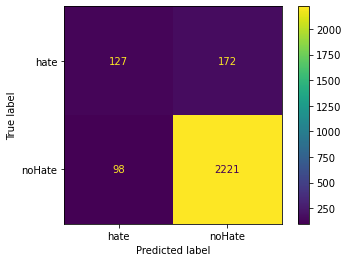

In [77]:
# Get the accuracy
print('Test Accuracy: '+str(svm.score(X_test, y_test)))
# Create confusion matrix
cm = confusion_matrix(y_test, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using all the available txt files with text pre-processing on a SVM Model returned an accuracy of 0.87 which is already higher than the paper's reported results. 

## Using the sampled train and test dataset

### Load the provided sampled_train and sampled_test dataset

In [47]:
# Sampled Training Data
# Load the annotations metadata csv to get label info
annot_tr = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot_tr.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot_tr['message']=''
# Loop through all lines
for i in range(len(annot_tr['file_id'])):
    # Get current filename
    filename = annot_tr['file_id'][i]
    try:
        # Open the file and read the contents
        with open('hate-speech-dataset-master/sampled_train/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents to the message column
        annot_tr['message'][i]=contents
    except:
        print('File '+str(filename)+' not in train samples.')
# Drop file id
annot_tr.drop(columns=['file_id'],inplace=True)

# Sampled Test Data
# Load the annotations metadata csv to get label info
annot_ts = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot_ts.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot_ts['message']=''
# Loop through all lines
for i in range(len(annot_ts['file_id'])):
    # Get current filename
    filename = annot_ts['file_id'][i]
    try:
        # Open the file and read the contents
        with open('hate-speech-dataset-master/sampled_test/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents to the message column
        annot_ts['message'][i]=contents
    except:
        print('File '+str(filename)+' not in test samples.')
# Drop file id
annot_ts.drop(columns=['file_id'],inplace=True)

File 12834217_1 not in train samples.
File 12834217_3 not in train samples.
File 12834217_5 not in train samples.
File 12834217_6 not in train samples.
File 12834217_7 not in train samples.
File 12834217_8 not in train samples.
File 12834217_9 not in train samples.
File 12834217_10 not in train samples.
File 12843221_1 not in train samples.
File 12843221_2 not in train samples.
File 12845600_1 not in train samples.
File 12845600_2 not in train samples.
File 12845600_3 not in train samples.
File 12845600_4 not in train samples.
File 12845808_1 not in train samples.
File 12845808_2 not in train samples.
File 12849464_1 not in train samples.
File 12849464_3 not in train samples.
File 12849464_4 not in train samples.
File 12851329_1 not in train samples.
File 12851329_2 not in train samples.
File 12851329_3 not in train samples.
File 12854837_1 not in train samples.
File 12854837_2 not in train samples.
File 12854837_3 not in train samples.
File 12854837_4 not in train samples.
File 128553

### EDA and Pre-Processing

In [48]:
# Keep sentences classified only as noHate and hate - Train Sample
cleanPosts_tr = annot_tr[(annot_tr['label'] != 'relation') & (annot_tr['label'] != 'idk/skip')]
# Reset index
cleanPosts_tr = cleanPosts_tr.reset_index(drop=True)

# Keep sentences classified only as noHate and hate - Test Sample
cleanPosts_ts = annot_ts[(annot_ts['label'] != 'relation') & (annot_ts['label'] != 'idk/skip')]
# Reset index
cleanPosts_ts = cleanPosts_ts.reset_index(drop=True)

#### WordCloud for Posts Classified as Hate

Train Sample

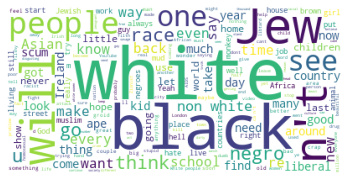

In [49]:
# WordCloud for posts classified as hate - Train Sample
wc_hate_tr = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_tr['message'][cleanPosts_tr['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tr)
plt.axis("off")
plt.show()

Test Sample

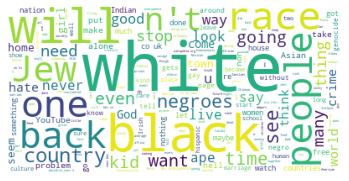

In [50]:
# WordCloud for posts classified as hate - Test Sample
wc_hate_ts = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_ts['message'][cleanPosts_ts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_ts)
plt.axis("off")
plt.show()

#### WordCloud for Posts Classified as noHate

Train Sample

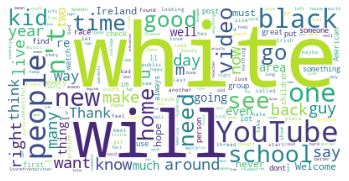

In [51]:
# WordCloud for posts classified as noHate - Train Sample
wc_noHate_tr = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_tr['message'][cleanPosts_tr['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tr)
plt.axis("off")
plt.show()

Test Sample

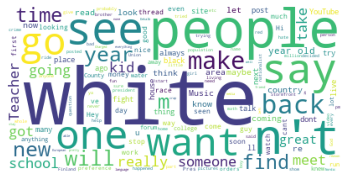

In [52]:
# WordCloud for posts classified as noHate - Test Sample
wc_noHate_ts = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_ts['message'][cleanPosts_ts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_ts)
plt.axis("off")
plt.show()

### Recreating Paper Results

#### Pre-Process text with SpaCy

Train Sample

In [53]:
# Instantiate SpaCy's English module - Train Sample
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts_tr['clean_message'] = cleanPosts_tr.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts_tr.drop(columns='message', inplace=True)

Test Sample

In [54]:
# Instantiate SpaCy's English module - Test Sample
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts_ts['clean_message'] = cleanPosts_ts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts_ts.drop(columns='message', inplace=True)

#### Drop rows with empty strings

Train Sample

In [55]:
# Drop rows where 'clean_message' is an empty string - Train Sample
# Get index
idx = cleanPosts_tr[cleanPosts_tr['clean_message'] == ''].index
# Drop rows based on index
cleanPosts_tr.drop(index=idx, inplace=True)

Test Sample

In [56]:
# Drop rows where 'clean_message' is an empty string - Train Sample
# Get index
idx = cleanPosts_ts[cleanPosts_ts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts_ts.drop(index=idx, inplace=True)

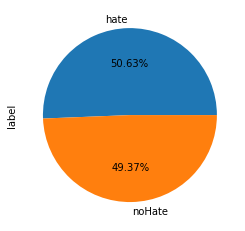

In [57]:
# Plot the class distribution - Train
plot_tr = cleanPosts_tr.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

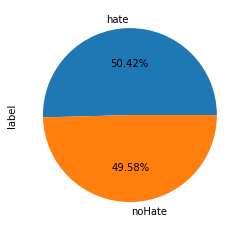

In [58]:
# Plot the class distribution - Test
plot_ts = cleanPosts_ts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Bag-of-Words Vectors

In [71]:
# Combine the train and test samples to use for the BoW vocabulary
cleanPosts_cb = pd.concat([cleanPosts_tr, cleanPosts_ts])
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Create the vocabulary
vectorizer.fit(cleanPosts_cb.clean_message.to_list())

# Transform train sample to document-term matrix
X_tr = vectorizer.transform(cleanPosts_tr.clean_message.to_list())
# Create a dataframe from the document-term matrix
X_train_b = pd.DataFrame(X_tr.toarray(),columns=vectorizer.get_feature_names_out())

# Transform test sample to document-term matrix
X_ts = vectorizer.transform(cleanPosts_ts.clean_message.to_list())
# Create a dataframe from the document-term matrix
X_test_b = pd.DataFrame(X_ts.toarray(),columns=vectorizer.get_feature_names_out())

#### Train the SVM Model

In [82]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train_b, cleanPosts_tr.label)
# Get prediction on test data
pred = svm.predict(X_test_b)

#### Get Accuracy and Confusion Matrix

Test Accuracy: 0.7436440677966102


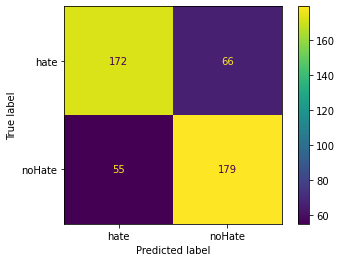

In [83]:
# Get the accuracy
print('Test Accuracy: '+str(svm.score(X_test_b, cleanPosts_ts.label)))
# Create confusion matrix
cm = confusion_matrix(cleanPosts_ts.label, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()